In [59]:
import numpy as np
from scipy.signal import welch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch, coherence

def extract_addiction_features(eeg_data, sampling_rate=128):
    """Extract addiction-relevant features from EEG data with 5 channels."""
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    # Get channel names (assuming first column is Time)
    channels = eeg_data.columns[1:]
    num_channels = len(channels)
    
    # Initialize feature DataFrames
    times = eeg_data['Timestamp'].values
    features = pd.DataFrame({
        'Time': times,
        'Theta_Beta_Ratio': np.zeros(len(times)),
        'Mean_Alpha_Power': np.zeros(len(times)),
        'Mean_Gamma_Power': np.zeros(len(times)),
        'Frontal_Alpha_Asymmetry': np.zeros(len(times)),
        'Delta_Beta_Ratio': np.zeros(len(times))
    })
    
    # Window size (in samples)
    window_size = int(sampling_rate * 1)  # 1 second windows
    
    # Process data in windows
    for i in range(0, len(times) - window_size, window_size):
        window_data = eeg_data.iloc[i:i+window_size, 1:].values
        
        # Calculate band powers for each channel
        band_powers = {band: np.zeros(num_channels) for band in bands}
        
        for ch in range(num_channels):
            channel_data = window_data[:, ch]
            
            # Calculate power spectral density
            freqs, psd = welch(channel_data, fs=sampling_rate, nperseg=min(256, len(channel_data)))
            
            # Extract band powers
            for band_name, (low_freq, high_freq) in bands.items():
                idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
                if np.any(idx_band):
                    band_powers[band_name][ch] = np.mean(psd[idx_band])
        
        # Calculate features for this window
        theta_power = np.mean(band_powers['theta'])
        beta_power = np.mean(band_powers['beta'])
        delta_power = np.mean(band_powers['delta'])
        
        # Avoid division by zero
        if beta_power > 0:
            features.loc[i:i+window_size-1, 'Theta_Beta_Ratio'] = theta_power / beta_power
            features.loc[i:i+window_size-1, 'Delta_Beta_Ratio'] = delta_power / beta_power
        
        features.loc[i:i+window_size-1, 'Mean_Alpha_Power'] = np.mean(band_powers['alpha'])
        features.loc[i:i+window_size-1, 'Mean_Gamma_Power'] = np.mean(band_powers['gamma'])
        
        # Calculate frontal alpha asymmetry if we have frontal channels
        if 'EEG.AF3' in channels and 'EEG.AF4' in channels:
            af3_idx = list(channels).index('EEG.AF3')
            af4_idx = list(channels).index('EEG.AF4')
            features.loc[i:i+window_size-1, 'Frontal_Alpha_Asymmetry'] = band_powers['alpha'][af4_idx] - band_powers['alpha'][af3_idx]
    
    return features

def plot_addiction_features(features):
    """Plot addiction-related features over time."""
    plt.figure(figsize=(12, 15))
    
    # Plot 1: Theta/Beta Ratio
    plt.subplot(5, 1, 1)
    plt.plot(features['Time'], features['Theta_Beta_Ratio'], color='blue')
    plt.ylabel('Theta/Beta Ratio')
    plt.title('Addiction-Related EEG Features')
    plt.grid(True)
    
    # Plot 2: Mean Alpha Power
    plt.subplot(5, 1, 2)
    plt.plot(features['Time'], features['Mean_Alpha_Power'], color='green')
    plt.ylabel('Mean Alpha Power')
    plt.grid(True)
    
    # Plot 3: Mean Gamma Power
    plt.subplot(5, 1, 3)
    plt.plot(features['Time'], features['Mean_Gamma_Power'], color='red')
    plt.ylabel('Mean Gamma Power')
    plt.grid(True)
    
    # Plot 4: Frontal Alpha Asymmetry
    plt.subplot(5, 1, 4)
    plt.plot(features['Time'], features['Frontal_Alpha_Asymmetry'], color='purple')
    plt.ylabel('Frontal Alpha Asymmetry')
    plt.grid(True)
    
    # Plot 5: Delta/Beta Ratio
    plt.subplot(5, 1, 5)
    plt.plot(features['Time'], features['Delta_Beta_Ratio'], color='orange')
    plt.xlabel('Time (s)')
    plt.ylabel('Delta/Beta Ratio')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('addiction_features.png')
    plt.show()

def plot_band_powers(eeg_data, sampling_rate=128):
    """Plot band powers over time for all channels."""
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    # Window size (in samples)
    window_size = int(sampling_rate * 1)  # 1 second windows
    
    # Initialize band powers
    times = []
    band_powers = {band: [] for band in bands}
    
    # Process data in windows
    for i in range(0, len(eeg_data) - window_size, window_size):
        window_data = eeg_data.iloc[i:i+window_size, 1:].values
        times.append(eeg_data.iloc[i + window_size//2, 0])
        
        # Calculate average band powers across all channels
        for band_name, (low_freq, high_freq) in bands.items():
            band_power = 0
            
            for ch in range(window_data.shape[1]):
                channel_data = window_data[:, ch]
                
                # Calculate power spectral density
                freqs, psd = welch(channel_data, fs=sampling_rate, nperseg=min(256, len(channel_data)))
                
                # Extract band power
                idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
                if np.any(idx_band):
                    band_power += np.mean(psd[idx_band])
            
            band_powers[band_name].append(band_power / window_data.shape[1])
    
    # Plot band powers
    plt.figure(figsize=(12, 6))
    
    for band_name, powers in band_powers.items():
        plt.plot(times, powers, label=band_name.capitalize())
    
    plt.xlabel('Time (s)')
    plt.ylabel('Band Power')
    plt.title('EEG Band Powers Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig('band_powers.png')
    plt.show()

def plot_coherence_map(eeg_data, sampling_rate=128):
    """Plot coherence map between channels."""
    # Get channel names (assuming first column is Time)
    channels = eeg_data.columns[1:]
    num_channels = len(channels)
    
    # Initialize coherence matrix
    coherence_matrix = np.zeros((num_channels, num_channels))
    
    # Calculate coherence between each pair of channels
    for i in range(num_channels):
        for j in range(num_channels):
            if i == j:
                coherence_matrix[i, j] = 1.0
            else:
                # Get channel data
                ch1_data = eeg_data.iloc[:, i+1].values
                ch2_data = eeg_data.iloc[:, j+1].values
                
                # Calculate coherence
                freqs, coh = coherence(ch1_data, ch2_data, fs=sampling_rate, nperseg=min(256, len(ch1_data)))
                
                # Average coherence in alpha band (8-13 Hz)
                alpha_mask = np.logical_and(freqs >= 8, freqs <= 13)
                if np.any(alpha_mask):
                    coherence_matrix[i, j] = np.mean(coh[alpha_mask])
    
    # Plot coherence matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(coherence_matrix, xticklabels=channels, yticklabels=channels, 
                cmap='coolwarm', annot=True, vmin=0, vmax=1)
    plt.title('Alpha Band Coherence Between Channels')
    plt.tight_layout()
    plt.savefig('coherence_map.png')
    plt.show()



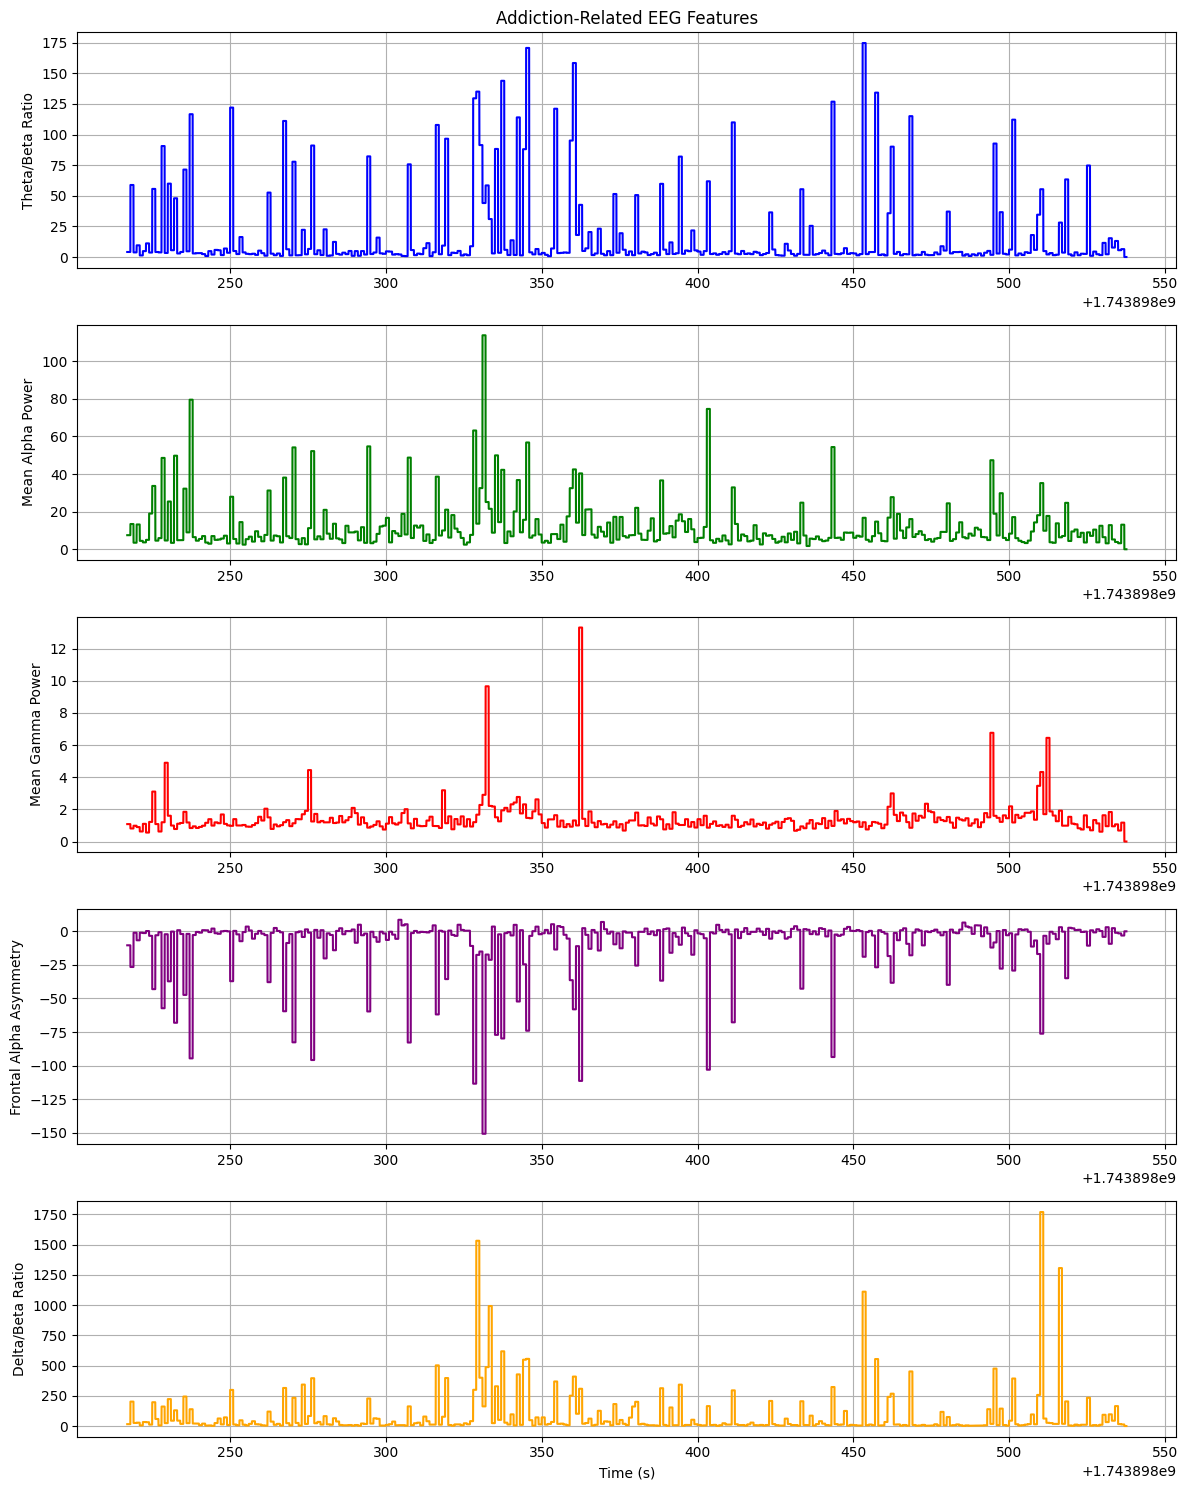

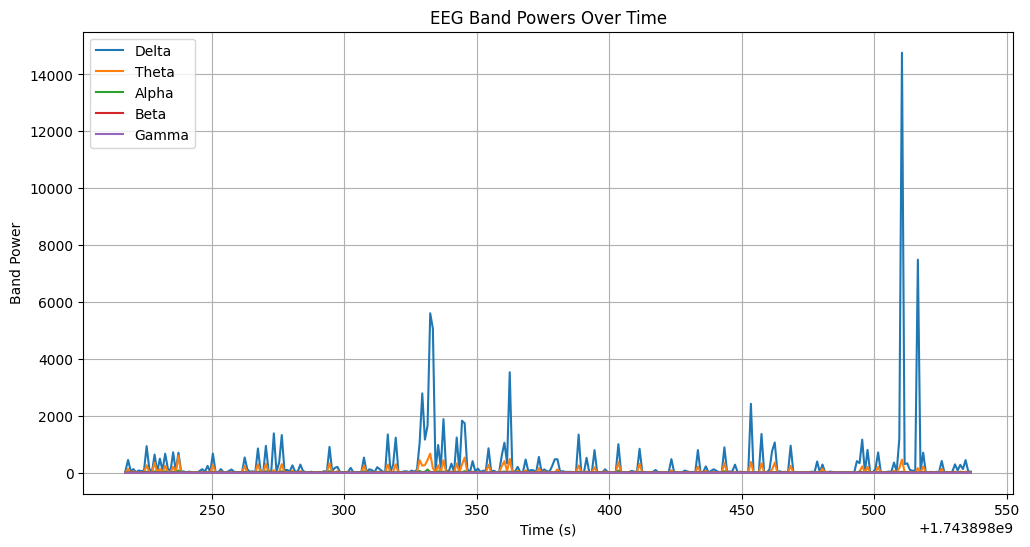

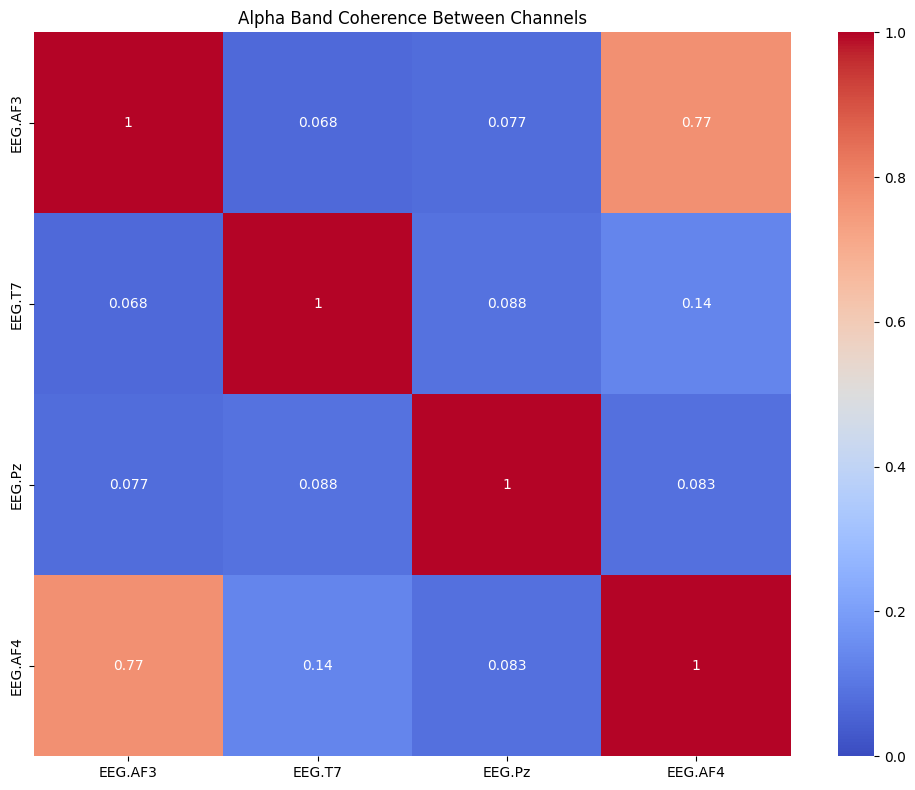

In [61]:
eeg_data = pd.read_csv('Agam Reels_INSIGHT2_283200_2025.04.05T17.10.16.07.00.md.mc.pm.fe.bp.csv')
eeg_data = eeg_data[["Timestamp", "EEG.AF3",	"EEG.T7",	"EEG.Pz",	"EEG.AF4"]]
# Extract features
features = extract_addiction_features(eeg_data)

# Plot addiction-related features
plot_addiction_features(features)

# Plot band powers
plot_band_powers(eeg_data)

# Plot coherence map
plot_coherence_map(eeg_data)

# print("All plots generated successfully.")

In [62]:
eeg_data1 = pd.read_csv('Agam Reels_INSIGHT2_283200_2025.04.05T17.10.16.07.00.md.mc.pm.fe.bp.csv')
eeg_data1 = eeg_data1[["Timestamp", "EEG.AF3", "EEG.T7", "EEG.Pz", "EEG.AF4"]]
eeg_data1 = eeg_data1.iloc[640:]
eeg_data1 = eeg_data1.reset_index(drop=True)  # Reset index after slicing
eeg_data1

,Timestamp,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4
0,1.743898e+09,4205.128418,4230.000000,4072.051270,4209.615234
1,1.743898e+09,4210.256348,4248.077148,4071.538574,4209.102539
2,1.743898e+09,4208.589844,4253.333496,4066.025635,4203.589844
3,1.743898e+09,4196.922852,4235.512695,4066.666748,4195.384766
4,1.743898e+09,4196.538574,4233.589844,4068.205078,4197.179688
...,...,...,...,...,...
40404,1.743899e+09,4211.410156,4226.666504,4074.230713,4195.641113
40405,1.743899e+09,4217.948730,4236.282227,4086.923096,4210.000000
40406,1.743899e+09,4215.000000,4250.128418,4084.230713,4216.922852
40407,1.743899e+09,4217.563965,4240.128418,4072.820557,4210.897461


In [63]:
eeg_data2 = pd.read_csv("Agam Reels 2_INSIGHT2_283200_2025.04.05T17.43.12.07.00.md.mc.pm.fe.bp.csv")
eeg_data2 = eeg_data2[["Timestamp", "EEG.AF3", "EEG.T7", "EEG.Pz", "EEG.AF4"]]
eeg_data2 = eeg_data2.iloc[640:]
eeg_data2 = eeg_data2.reset_index(drop=True)  # Reset index after slicing
eeg_data2

,Timestamp,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4
0,1.743900e+09,4329.743652,4305.256348,4172.307617,4291.538574
1,1.743900e+09,4329.230957,4297.692383,4171.666504,4303.077148
2,1.743900e+09,4323.333496,4260.384766,4148.589844,4295.384766
3,1.743900e+09,4317.563965,4264.871582,4129.615234,4286.666504
4,1.743900e+09,4320.897461,4298.846191,4139.743652,4294.358887
...,...,...,...,...,...
120465,1.743901e+09,4332.307617,4277.436035,4097.948730,4256.410156
120466,1.743901e+09,4301.794922,4246.025879,4076.281982,4230.256348
120467,1.743901e+09,4289.871582,4209.871582,4071.153809,4225.641113
120468,1.743901e+09,4265.897461,4189.743652,4057.948730,4200.641113


## Reels History Data

In [95]:
history = pd.read_csv("history.csv")
# convert 00:00:00 to seconds 
history['time spent on this reel'] = pd.to_timedelta(history['time spent on this reel']).dt.total_seconds()
# reverse the order of the history DataFrame
history = history[::-1].reset_index(drop=True)
history

,time,url,time spent on this reel
0,17:10:21,https://www.instagram.com/reels/DHl1NfMsE-a/,41.0
1,17:11:02,https://www.instagram.com/reels/DHq67Pfvpkm/,9.0
2,17:11:11,https://www.instagram.com/reels/DCZgltAh7mI/,6.0
3,17:11:17,https://www.instagram.com/reels/DG-5yNEJjJX/,25.0
4,17:11:42,https://www.instagram.com/reels/DFbAj8FyW06/,18.0
...,...,...,...
97,17:57:25,https://www.instagram.com/reels/DHrh66Dui-7/,4.0
98,17:57:29,https://www.instagram.com/reels/DHt0rz2BFt7/,7.0
99,17:57:36,https://www.instagram.com/reels/DHmbQG1saBl/,15.0
100,17:57:51,https://www.instagram.com/reels/DHlVfGjOEGJ/,3.0


In [58]:
# get index of 17:15:02 in history["time"]
history_index = history[history['time'] == '17:15:02'].index
history_index

Index([23], dtype='int64')

In [105]:
# 17:15:02 cutting time 
all_data = history.copy()
AF3 = []
T7 = []
Pz = []
AF4 = []
curr_ind1 = 0
curr_ind2 = 0
for i, row in history.iterrows():
    time_spent = row['time spent on this reel']
    num_rows = int(time_spent * 128)

    if i <= 23:
        # average the EEG values for the columns EEG.AF3, EEG.T7, EEG.Pz, EEG.AF4 for the next num_rows of eeg_data1
        af3_avg = eeg_data1.iloc[curr_ind1 : curr_ind1 + num_rows]['EEG.AF3'].mean()
        t7_avg = eeg_data1.iloc[curr_ind1 : curr_ind1 + num_rows]['EEG.T7'].mean()
        pz_avg = eeg_data1.iloc[curr_ind1 : curr_ind1 + num_rows]['EEG.Pz'].mean()
        af4_avg = eeg_data1.iloc[curr_ind1 : curr_ind1 + num_rows]['EEG.AF4'].mean()
        AF3.append(af3_avg)
        T7.append(t7_avg)
        Pz.append(pz_avg)
        AF4.append(af4_avg)
        curr_ind1 += num_rows
    else:
        # average the EEG values for the columns EEG.AF3, EEG.T7, EEG.Pz, EEG.AF4 for the next num_rows of eeg_data2
        af3_avg = eeg_data2.iloc[curr_ind2 : curr_ind2 + num_rows]['EEG.AF3'].mean()
        t7_avg = eeg_data2.iloc[curr_ind2 : curr_ind2 + num_rows]['EEG.T7'].mean()
        pz_avg = eeg_data2.iloc[curr_ind2 : curr_ind2 + num_rows]['EEG.Pz'].mean()
        af4_avg = eeg_data2.iloc[curr_ind2 : curr_ind2 + num_rows]['EEG.AF4'].mean()
        AF3.append(af3_avg)
        T7.append(t7_avg)
        Pz.append(pz_avg)
        AF4.append(af4_avg)
        curr_ind2 += num_rows

all_data['EEG.AF3'] = AF3
all_data['EEG.T7'] = T7
all_data['EEG.Pz'] = Pz
all_data['EEG.AF4'] = AF4
all_data

,time,url,time spent on this reel,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4
0,17:10:21,https://www.instagram.com/reels/DHl1NfMsE-a/,41.0,4230.400374,4243.084936,4082.138078,4220.904204
1,17:11:02,https://www.instagram.com/reels/DHq67Pfvpkm/,9.0,4227.094920,4246.773727,4082.154553,4220.463637
2,17:11:11,https://www.instagram.com/reels/DCZgltAh7mI/,6.0,4211.022630,4223.947483,4063.663529,4206.160854
3,17:11:17,https://www.instagram.com/reels/DG-5yNEJjJX/,25.0,4234.912460,4246.478404,4086.333774,4225.174516
4,17:11:42,https://www.instagram.com/reels/DFbAj8FyW06/,18.0,4228.611778,4244.216854,4081.364519,4220.788039
...,...,...,...,...,...,...,...
97,17:57:25,https://www.instagram.com/reels/DHrh66Dui-7/,4.0,4211.387717,4210.235124,4065.204580,4206.110530
98,17:57:29,https://www.instagram.com/reels/DHt0rz2BFt7/,7.0,4238.923859,4236.365614,4090.300773,4227.251320
99,17:57:36,https://www.instagram.com/reels/DHmbQG1saBl/,15.0,4235.776982,4233.846416,4086.978430,4223.465876
100,17:57:51,https://www.instagram.com/reels/DHlVfGjOEGJ/,3.0,4225.301470,4234.955928,4087.084669,4220.840672


In [ ]:
reel_labels = pd.read_csv("reel_labels.csv")
# reverse the order of the reel_labels DataFrame
reel_labels = reel_labels[::-1].reset_index(drop=True)
reel_labels = reel_labels[["time", "Unnamed: 3"]]
reel_labels

,time,Unnamed: 3
0,17:10:21,Interested
1,17:11:02,Sad
2,17:11:11,Funny
3,17:11:17,Funny
4,17:11:42,Funny
...,...,...
99,17:57:25,Neutral
100,17:57:29,Funny
101,17:57:36,Funny
102,17:57:51,Excited


In [108]:
labels = reel_labels["Unnamed: 3"].tolist()
for i in range(len(labels)):
    if labels[i] == "Neutral" or labels[i] == "neutral":
        labels[i] = "Neutral"
    elif labels[i] == "Interested" or labels[i] == "interested" or labels[i] == "Interesed" or labels[i] == "Interesting":
        labels[i] = "Interested"
reel_labels["Labels"] = labels
dic = {}
for i, row in reel_labels.iterrows():
    dic[row["time"]] = row['Labels']

pd.Series(labels).value_counts()

Neutral       35
Interested    22
Sad           17
Funny         14
Excited       14
Name: count, dtype: int64

In [109]:
labels = []
for i, row in all_data.iterrows():
    time = row['time']
    labels.append(dic[time])
all_data['Label'] = labels
all_data

,time,url,time spent on this reel,EEG.AF3,EEG.T7,EEG.Pz,EEG.AF4,label,Label
0,17:10:21,https://www.instagram.com/reels/DHl1NfMsE-a/,41.0,4230.400374,4243.084936,4082.138078,4220.904204,Interested,Interested
1,17:11:02,https://www.instagram.com/reels/DHq67Pfvpkm/,9.0,4227.094920,4246.773727,4082.154553,4220.463637,Sad,Sad
2,17:11:11,https://www.instagram.com/reels/DCZgltAh7mI/,6.0,4211.022630,4223.947483,4063.663529,4206.160854,Funny,Funny
3,17:11:17,https://www.instagram.com/reels/DG-5yNEJjJX/,25.0,4234.912460,4246.478404,4086.333774,4225.174516,Funny,Funny
4,17:11:42,https://www.instagram.com/reels/DFbAj8FyW06/,18.0,4228.611778,4244.216854,4081.364519,4220.788039,Funny,Funny
...,...,...,...,...,...,...,...,...,...
97,17:57:25,https://www.instagram.com/reels/DHrh66Dui-7/,4.0,4211.387717,4210.235124,4065.204580,4206.110530,Neutral,Neutral
98,17:57:29,https://www.instagram.com/reels/DHt0rz2BFt7/,7.0,4238.923859,4236.365614,4090.300773,4227.251320,Funny,Funny
99,17:57:36,https://www.instagram.com/reels/DHmbQG1saBl/,15.0,4235.776982,4233.846416,4086.978430,4223.465876,Funny,Funny
100,17:57:51,https://www.instagram.com/reels/DHlVfGjOEGJ/,3.0,4225.301470,4234.955928,4087.084669,4220.840672,Excited,Excited
